# Summarisation and Controlled Text Generation with T-5

In this notebook, we will see how to fine-tune one of the [HuggingFace Transformers](https://github.com/huggingface/transformers) model (T5) for the summarisation task and the task of controlled text generation with keywords. We will use the [XSum dataset](https://arxiv.org/pdf/1808.08745.pdf) (for extreme summarisation) which contains long BBC articles and their single-sentence summaries.

[T5](https://paperswithcode.com/method/t5) is a popular model, which is designed as a text-to-text multi-task model. For each task, both input and output is text (so that for a regression task, a number 2.5 becomes a string "2.5"). Hence we can use the same model for a range of tasks including translation, linguistic acceptability, sentence similarity, document summarisation (our case), etc.

We will start by installing 🤗 Huggingface Transformers and 🤗 Huggingface Datasets as well as other dependencies.

Much of our code is based on the [official tutorial](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/summarization-tf.ipynb).

In [1]:
! pip install transformers
! pip install -U datasets evaluate
! pip install rouge-score nltk
! pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=a6131c8a469893e8ad427801e691ecd3bfc1ab09037c32abb7a7f953b7ddcaf0
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


## Loading the Dataset




We will use the [HuggingFace Datasets](https://github.com/huggingface/datasets) library to download the data. This a very good resource for easy manipulation of commonly used datasets.

In [2]:
!datasets-cli env


Copy-and-paste the text below in your GitHub issue.

- `datasets` version: 3.4.0
- Platform: Linux-6.1.85+-x86_64-with-glibc2.35
- Python version: 3.11.11
- `huggingface_hub` version: 0.28.1
- PyArrow version: 18.1.0
- Pandas version: 2.2.2
- `fsspec` version: 2024.10.0



In [3]:
from datasets import load_dataset

# If the training time is too much and you do not have GPU / TPU then uncomment the below line and re-run the notebook
# Note that here we are reducing the size of the dataset hence the values are going to be different then what you will see when you run it on full dataset
# original_datasets = load_dataset("xsum", trust_remote_code=True, split="validation[:2%]")
original_datasets = load_dataset("xsum", trust_remote_code=True, split="validation[:10%]")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.24k [00:00<?, ?B/s]

xsum.py:   0%|          | 0.00/5.76k [00:00<?, ?B/s]

(…)SUM-EMNLP18-Summary-Data-Original.tar.gz:   0%|          | 0.00/255M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

We will further create a train and a validation set by splitting the original validation set.

In [4]:
import datasets as ds

# We will use only the validation set due to the lack of computational resources
# Split the initial validation set
train_valid = original_datasets.train_test_split(test_size=0.25)

# Gather the sets into a single DatasetDict
raw_datasets = ds.DatasetDict({'train': train_valid['train'], 'validation': train_valid['test']})

In [5]:
print(raw_datasets["train"][0])

{'document': 'The Bluebirds could receive up to £5m for the Scotland goalkeeper.\nBut Giles says the 31-year-old is worth at least £8m, underlining Cardiff\'s malaise in the Championship.\n"They are going to get £3.5m and they\'re selling him on the cheap. And that tells me where the club is going: nowhere," said Giles.\nMarshall agreed personal terms with Hull after being omitted from Saturday\'s Championship defeat by Reading.\nThe 31-year-old has made more than 280 appearances for Cardiff since arriving from Norwich City for free in 2009.\nCardiff are 17th in the 24-strong division with one win, two draws and two defeats.\nMarshall is widely regarded as their star player and Giles, who had two playing stints with the club lasting a combined total of six years, is unhappy at the player leaving.\n"I think it\'s a joke. Personally I think David Marshall is worth £8m, probably more than that to any club," said Giles before Marshall\'s move was finalised.\n"Football today, I hate it, all

### Some Data Analysis

Here we will perform some basic exploratory data analysis by computing the mean and standard deviation of token counts for the source and target documents.

The `show_random_elements` method below displays a table containing `num_examples` samples from the specified `dataset`, with fields `document`, `summary` and `id`

**Task 1: Summarisation data statistics**

Complete the functions below by tokenising the documents (the best option would be to use the tokeniser but here you can just split on spaces) and print the mean token count and standard deviation for source and target documents for each dataset. Plot histograms of the source and target token counts (method `show_token_counts` is provided). Comment on the lengths of input and target texts for summarisation.

,document,summary,id
0,"Morgan King, a single mother, had apologised to her professor for being absent due to childcare problems.\nThe University of Tennessee professor emailed to say she could bring her daughter, Korbyn, to lessons and she would be ""delighted"" to hold her.\nMs King said the warm words made her cry.\nIn an interviewed with US news channel WBIR-TV, she said: ""I just didn't know what else to do. I emailed my professor after class and was apologising for missing class that day.""\nProfessor Sally Hunter, from Knoxville, then wrote back with her ""very serious"" offer of help.\n""Let me know if there are any other ways I could be supporting you,"" she said, before signing off.\nMs King shared the email on Twitter and it was shared thousands of times.\nOn Wednesday, the university's chancellor, Beverly Davenport, responded: ""Morgan, thanks for showing us challenges college students face. Prof Hunter, thanks for being part of the solution.""\nMs King said her professor, who teaches in the Department of Child and Family Studies, is not on Twitter and is nonplussed by the reaction.\n""She just doesn't think she did anything special, which speaks about the kind of person she is,"" Ms King told WBIR-TV.\nThe student said she has not needed to take her up on the offer yet.\nWhen she graduates she hopes to become a recreational therapist, working with children with disabilities.\n""I have to get my degree for Korbyn, not just for me. It means a lot that people are really supportive,"" Ms King said.",A US student with a three-month-old baby has expressed gratitude to a teacher who offered to babysit so she would not miss classes.,40394427
1,"He walked alone and in silence around the concentration and extermination camp in what was Nazi-occupied Poland where 1.1 million people, mostly Jews, were killed.\nPope Francis also met elderly survivors of the camp, kissing them on the cheeks and speaking to them softly.\nHe is on his third day of a visit marking 1,050 years since Poland's adoption of Christianity.\nFrancis has become the third Pope to walk through the main gate of Auschwitz, under its infamous inscription ""Arbeit Macht Frei"" - work sets you free.\nBut unlike his German and Polish predecessors, he is not speaking about the horrors that occurred there, says the BBC's Adam Easton in Warsaw.\nFrancis passed under the gates alone, wearing white robes and skullcap. After meeting the survivors, he placed a candle at the Death Wall, where prisoners were executed by the Nazis, before continuing on his own.\nThe Pope stopped to pray at the prison cell of Maximilian Kolbe, a Polish Catholic friar who sacrificed his life to save that of another man. The Church made him a saint in 1982.\nPope Francis knelt for many minutes in the underground cell, illuminated only by the light from a tiny window, the Associated Press news agency reports.\nThe Argentine Pope is on a five-day trip to Poland.\nDuring a World Youth Day rally in the southern city of Krakow on Thursday, he urged compassion for migrants.\nHe told hundreds of thousands of people that ""a merciful heart opens up to welcome refugees and migrants"" - a statement that puts him at odds with Poland's anti-immigrant right-wing government.",The Pope has offered a private prayer at the former Auschwitz death camp.,36921636
2,"After the show, a cast member thanked Mr Pence for attending and read a letter to him on stage.\n""We, sir, are the diverse America who are alarmed and anxious that your new administration will not protect us,"" Brandon Dixon said.\nThe incident has angered President-elect Donald Trump, who has accused the cast of ""harassing"" his running mate.\nThe President-elect has gone as far as to demand an apology to a ""very good man"", apparently misunderstanding that the cast implored the audience to stop booing Mr Pence.\n""Our wonderful future V.P. Mike Pence was harassed last night at the theater by the cast of Hamilton, cameras blazing. This should not 

Statistics for train set:
  Source Documents: Mean = 371.50, Std = 315.83
  Target Summaries: Mean = 21.05, Std = 5.17

Statistics for validation set:
  Source Documents: Mean = 375.52, Std = 277.19
  Target Summaries: Mean = 21.16, Std = 5.53



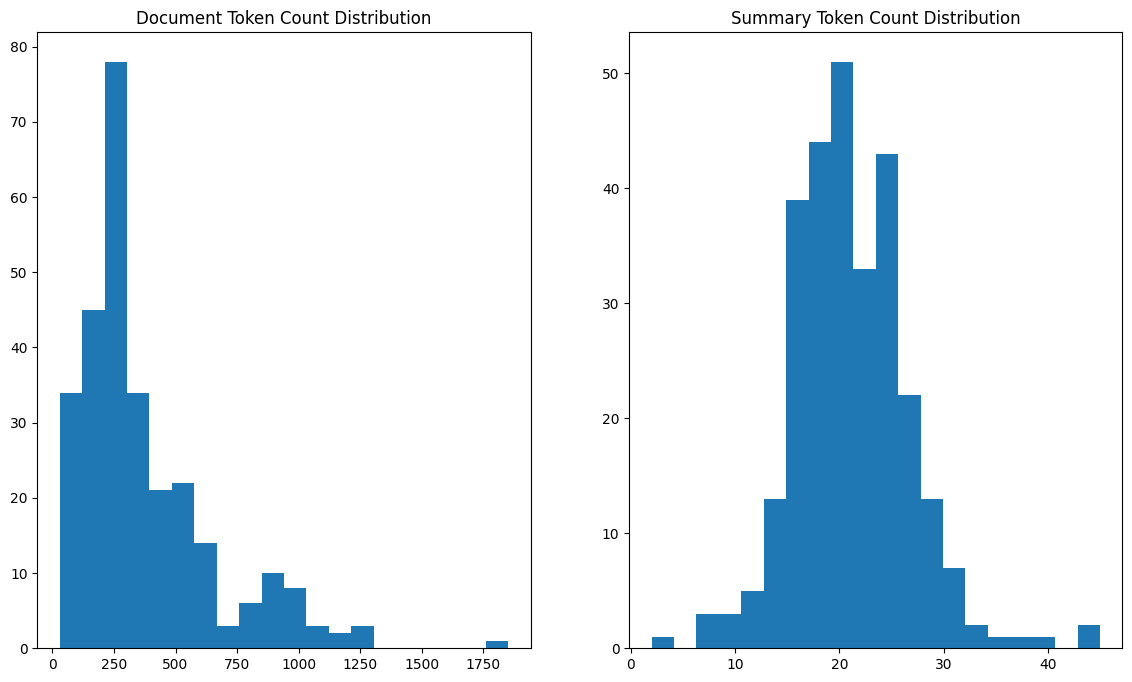

In [6]:
import datasets
import random
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

"""
Task 1

Begin
"""

def calculate_token_counts(dataset):
    source_counts = [len(doc.split()) for doc in dataset["document"]]
    target_counts = [len(summary.split()) for summary in dataset["summary"]]
    return source_counts, target_counts
def token_counts_summary(raw_datasets):
 for split, dataset in raw_datasets.items():
        source_counts, target_counts = calculate_token_counts(dataset)
        print(f"Statistics for {split} set:")
        print(f"  Source Documents: Mean = {np.mean(source_counts):.2f}, Std = {np.std(source_counts):.2f}")
        print(f"  Target Summaries: Mean = {np.mean(target_counts):.2f}, Std = {np.std(target_counts):.2f}\n")

"""
End Task 1
"""

def show_token_counts(dataset):
    source_counts, target_counts = calculate_token_counts(dataset)
    f, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 8))
    ax0.hist(source_counts, bins=20)
    ax1.hist(target_counts, bins=20)
    ax0.set_title("Document Token Count Distribution")
    ax1.set_title("Summary Token Count Distribution")

show_random_elements(raw_datasets["validation"])
show_token_counts(raw_datasets["validation"])
token_counts_summary(raw_datasets)

### ROUGE Metric

To evaluate our model's performance, we will use **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**. It compares *n*-grams of the model outputs to reference text but is based on recall instead of precision like BLEU. ROUGE does not impose any brevity penalty. BLEU returns a single number, ROUGE outputs multiple scores per each $n$-gram under consideration.

This metric is provided natively within the dataset library. **Note** metrics are difficult to implement correctly from scratch as decisions like lemmatisation, tokenisation and punctation-handling can create large discrepancies in scores.

You can call its `compute` method with your hypotheses and target summaries, which need to be list of decoded strings:

In [7]:
import evaluate
metric = evaluate.load("rouge", trust_remote_code=True)

# help(metric)      # << Uncomment to see more about the ROUGE eval metric

predicted_summaries = ["AI applications span diverse fields.", "Enhancing efficiency, decision-making, experiences with AI."]
target_doc = 'As artificial intelligence continues to advance, researchers are exploring its applications in diverse fields such as healthcare, finance, education, and entertainment, aiming to improve efficiency, decision-making processes, and overall human experiences.'
docs = [target_doc, target_doc]

metric.compute(predictions=predicted_summaries, references=docs)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

{'rouge1': 0.18364518364518362,
 'rouge2': 0.08262548262548262,
 'rougeL': 0.18364518364518362,
 'rougeLsum': 0.18364518364518362}

## Preprocessing the Data

We will proprocess the data using the Huggingface `Tokenizer` paired with T5, which tokenises input text and adds additional required tokens. This ensures that our inputs are correctly aligned with the model's embedding matrix.

In [8]:
from transformers import AutoTokenizer

model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

### Using the Tokenizer

`Tokenizer` outputs are different for different tokenisers. Compare outputs below for the T5 and BERT tokenisers.


In [9]:
print(tokenizer("AI applications span diverse fields."))

tokenizer_ = AutoTokenizer.from_pretrained('bert-base-uncased')
tokenizer_('AI applications span diverse fields.')

{'input_ids': [7833, 1564, 8438, 2399, 4120, 5, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': [101, 9932, 5097, 8487, 7578, 4249, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

As we mentioned above, T5 was trained in a multitask setup such that it can perform multiple tasks. We prefix the inputs with "summarize: " to prompt the model to summarise.

We will now create a function to preprocess our samples, feeding them to the tokeniser with the `truncation=True` argument. This ensures that any input exceeding the model's maximum accepted length will be truncated accordingly. Padding will be addressed later in a data collator, allowing us to pad examples to the longest length in the batch rather than the entire dataset.

Complete the `preprocess_function` below to prepare our training data (**Hint**: do not forget to prefix the inputs).

In [13]:
if model_checkpoint in ["t5-small", "t5-base", "t5-large", "t5-3b", "t5-11b"]:
    prefix = "summarize: "
else:
    prefix = ""

In [14]:
max_doc_len = 1024
max_sum_length = 128


def preprocess_samples(samples):

    inputs = list()

    """
    Task 2 1/3

    Begin
    """
    inputs = [prefix + doc for doc in samples["document"]]
    model_inputs = tokenizer(inputs, max_length=max_doc_len, truncation=True)

    """
    End Task 2 1/3
    """

    targets = tokenizer(text_target = samples["summary"], max_length=max_sum_length, truncation=True)
    model_inputs["labels"] = targets["input_ids"]

    return model_inputs

This function works with one or several examples. In the case of several examples, the tokeniser will return a list of lists for each key:

In [15]:
raw_datasets["train"][:2]

{'document': ['The Bluebirds could receive up to £5m for the Scotland goalkeeper.\nBut Giles says the 31-year-old is worth at least £8m, underlining Cardiff\'s malaise in the Championship.\n"They are going to get £3.5m and they\'re selling him on the cheap. And that tells me where the club is going: nowhere," said Giles.\nMarshall agreed personal terms with Hull after being omitted from Saturday\'s Championship defeat by Reading.\nThe 31-year-old has made more than 280 appearances for Cardiff since arriving from Norwich City for free in 2009.\nCardiff are 17th in the 24-strong division with one win, two draws and two defeats.\nMarshall is widely regarded as their star player and Giles, who had two playing stints with the club lasting a combined total of six years, is unhappy at the player leaving.\n"I think it\'s a joke. Personally I think David Marshall is worth £8m, probably more than that to any club," said Giles before Marshall\'s move was finalised.\n"Football today, I hate it, al

In [16]:
preprocess_samples(raw_datasets["train"][:2])

{'input_ids': [[21603, 10, 37, 2419, 9414, 7, 228, 911, 95, 12, 23978, 51, 21, 8, 8288, 1288, 10477, 5, 299, 3156, 965, 845, 8, 2664, 18, 1201, 18, 1490, 19, 1494, 44, 709, 3996, 927, 51, 6, 365, 9424, 26911, 31, 7, 1460, 8284, 16, 8, 7666, 5, 96, 10273, 33, 352, 12, 129, 3996, 9285, 51, 11, 79, 31, 60, 3014, 376, 30, 8, 2877, 5, 275, 24, 817, 7, 140, 213, 8, 1886, 19, 352, 10, 16715, 976, 243, 3156, 965, 5, 17410, 4686, 525, 1353, 28, 3455, 195, 227, 271, 3, 32, 16030, 45, 1856, 31, 7, 7666, 9589, 57, 9825, 5, 37, 2664, 18, 1201, 18, 1490, 65, 263, 72, 145, 3, 17518, 3179, 7, 21, 26911, 437, 15315, 45, 30894, 896, 21, 339, 16, 10425, 26911, 33, 1003, 189, 16, 8, 12371, 25866, 4889, 28, 80, 1369, 6, 192, 14924, 11, 192, 9589, 7, 5, 17410, 19, 5456, 3, 12327, 38, 70, 2213, 1959, 11, 3156, 965, 6, 113, 141, 192, 1556, 28388, 7, 28, 8, 1886, 10139, 3, 9, 3334, 792, 13, 1296, 203, 6, 19, 24357, 44, 8, 1959, 3140, 5, 96, 196, 317, 34, 31, 7, 3, 9, 10802, 5, 21069, 27, 317, 1955, 17410, 19, 

We will apply the `map` method of our `raw_datasets` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [17]:
preprocessed_datasets = raw_datasets.map(preprocess_samples, batched=True, remove_columns=raw_datasets["train"].column_names)

Map:   0%|          | 0/849 [00:00<?, ? examples/s]

Map:   0%|          | 0/284 [00:00<?, ? examples/s]

The outcomes are automatically stored in the 🤗 Datasets library's cache, so that processing does not need to be repeated. If you need to reapply preprocessing, you can include `load_from_cache_file=False` in the map function call.

We specified `batched=True `to encode texts in batches which employs multi-threading.

## Fine-tuning T5

We will now download the pretrained model and fine-tune it. Since our task is sequence-to-sequence, we use the `AutoModelForSeq2SeqLM` class.

In [18]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Let's set the learning rate, `batch_size` and customise the weight decay.

In [19]:
batch_size = 8
learning_rate = 2e-5
weight_decay = 0.01
num_train_epochs = 5

model_name = model_checkpoint.split("/")[-1]
push_to_hub_model_id = f"{model_name}-finetuned-xsum"

Next, we build a data collator that pads the inputs to the batch's maximum length for both inputs ans targets. Make sure to set the `return_tensors='np'` argument to obtain NumPy arrays. Our TensorFlow dataset pipeline internally employs a NumPy loader, wrapped with a tf.data.Dataset at the end. Additionally, np is required by the ROUGE metrics.


To speed up GPU computation, we specify `pad_to_multiple_of`, which snaps the padding length to the next multiple of the given value. For example, if we pad to 250 but pad_to_multiple_of=8 then we will pad to 256.

In [20]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt", pad_to_multiple_of=128)

We will convert our datasets into tf.data.Dataset, to be able to work with Keras. We will use Model.prepare_tf_dataset() to avoid manual specification. We re-use the collator we created earlier as our `collate_fn`.

In [21]:
from torch.utils.data import DataLoader
from datasets import Dataset

# Convert datasets to PyTorch format
train_dataset = preprocessed_datasets["train"]
validation_dataset = preprocessed_datasets["validation"]

# Create DataLoaders for training and validation
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator
)

validation_dataloader = DataLoader(
    validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=data_collator
)

In [22]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 849
})

Now we initialise our loss and optimizer and compile the model.

In [23]:
from torch.optim import AdamW

# Define optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

Finally, we can train our model. KerasMetricCallback is a callback for computing advanced metrics. The callback takes two main arguments: `metric_fn` and `eval_dataset`. It then iterates the `eval_dataset` and collects the model's outputs for each sample. As a result, the callback passes the `list` of predictions and the associated `list` of targets to the user-defined `metric_fn`. If the `predict_with_generate` argument is `True`, then it will call `model.generate()`. This is useful for metrics like `ROUGE`.

Complete the `compute_metrics` below to decode output batches and compute ROUGE (**Hint**: you can use `tokenizer.batch_decode` and `metric.compute`).

In [27]:
# Evaluation metrics
def compute_metrics(eval_predictions):
    model_predictions, true_labels = eval_predictions

    # Replace masked true label tokens
    for label in true_labels:
        label[label < 0] = tokenizer.pad_token_id

    """
    Task 2 2/3

    Begin
    """
    # Decode predictions and labels
    decoded_predictions = tokenizer.batch_decode(model_predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(true_labels, skip_special_tokens=True)

    # Ensure Rouge expects a newline after each sentence
    decoded_predictions = [
        "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
    ]
    decoded_targets = [
        "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
    ]

    # Compute Rouge scores
    rouge_results =  metric.compute(predictions=decoded_predictions, references=decoded_targets)

    """
    End Task 2 2/3
    """

    # Extract relevant results
    rouge_results = {key: value.mid.fmeasure * 100 for key, value in rouge_results.items()}

    # Include mean generated length
    prediction_lengths = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in model_predictions
    ]
    rouge_results["gen_len"] = np.mean(prediction_lengths)

    return rouge_results


We will train our model now. We only do five epochs, as inputs are very long and even one epoch can take a while.

In [25]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [28]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training loop
for epoch in range(num_train_epochs):
    model.train()
    model.to(device)
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}: Training loss: {loss.item()}")

Epoch 1: Training loss: 3.098968982696533
Epoch 2: Training loss: 3.5333352088928223
Epoch 3: Training loss: 2.9322493076324463
Epoch 4: Training loss: 2.785102605819702
Epoch 5: Training loss: 2.7536585330963135


## Inference

Let's try now to summarise a document using our model. Do not forget to prepend "summarize: " to the input.

In [31]:
document = 'The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.\nRepair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.\nTrains on the west coast mainline face disruption due to damage at the Lamington Viaduct.\nMany businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.\nFirst Minister Nicola Sturgeon visited the area to inspect the damage.\nThe waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.\nJeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.\nHowever, she said more preventative work could have been carried out to ensure the retaining wall did not fail.\n"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate that - but it is almost like we\'re neglected or forgotten," she said.\n"That may not be true but it is perhaps my perspective over the last few days.\n"Why were you not ready to help us a bit more when the warning and the alarm alerts had gone out?"\nMeanwhile, a flood alert remains in place across the Borders because of the constant rain.\nPeebles was badly hit by problems, sparking calls to introduce more defences in the area.\nScottish Borders Council has put a list on its website of the roads worst affected and drivers have been urged not to ignore closure signs.\nThe Labour Party\'s deputy Scottish leader Alex Rowley was in Hawick on Monday to see the situation first hand.\nHe said it was important to get the flood protection plan right but backed calls to speed up the process.\n"I was quite taken aback by the amount of damage that has been done," he said.\n"Obviously it is heart-breaking for people who have been forced out of their homes and the impact on businesses."\nHe said it was important that "immediate steps" were taken to protect the areas most vulnerable and a clear timetable put in place for flood prevention plans.'
summary = 'Severe flooding in Newton Stewart and surrounding areas has caused extensive damage, ongoing repair efforts, disruptions to transportation, and calls for improved flood prevention measures, prompting visits from First Minister Nicola Sturgeon and concerns from local businesses and residents.'

"""
Task 2 3/3

Begin
"""
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
tokenized = tokenizer(prefix + document, return_tensors="pt", max_length=max_doc_len, truncation=True)

# Move tokenized input to the same device as the model
tokenized = {key: value.to(device) for key, value in tokenized.items()}


"""
End Task 2 3/3
"""

out = model.generate(**tokenized, max_length=128)

In [32]:
out_ft = tokenizer.decode(out[0], skip_special_tokens=True)
print(out_ft)

A flood warning has been issued in the area after the floods in Newton Stewart caused a flood warning and a flood warning.


## Pipeline API

The pipeline API provides a convienient shortcut to many procedures. Let's use it to generate a summary with the non fine-tuned model.

In [37]:
from transformers import pipeline

# we will use the initial T5 checkpoint we downloaded before fine-tuning
summarizer = pipeline('text2text-generation', model_checkpoint, framework="pt", device=device)

Device set to use cuda


**Task 2: Compare performance of the fine-tuned model to generic output**

Summarise the document provided above using the generic model (no fine-tuning). Compute ROUGE scores and comment on the efficiency of fine-tuning.

In [38]:
out = summarizer(document, max_length=128)
out_zero_shot = out[0]['generated_text']
print(out_zero_shot)

the flood protection plan was right but backed calls to speed up the process . the full cost of damage in Newton Stewart is still being assessed . many roads in Peeblesshire remain badly affected by standing water .


In [35]:
metric.compute(predictions=[out_ft], references=[summary])

{'rouge1': 0.22580645161290322,
 'rouge2': 0.06666666666666667,
 'rougeL': 0.1935483870967742,
 'rougeLsum': 0.1935483870967742}

In [36]:
metric.compute(predictions=[out_zero_shot], references=[summary])

{'rouge1': 0.18666666666666665,
 'rouge2': 0.05479452054794521,
 'rougeL': 0.08,
 'rougeLsum': 0.08}

## Textual data generation using keywords


One possible way to generate new text for data augmentation is to guide the generation of new text using keywords extracted from original data. In this task, you will fine-tune T5 to generate new text based on keywords extracted from the original summaries of the XSum dataset you have seen in the first part of this lab.  Fine-tuning T5 on such a task would leverage the model capabilities to produce new text that captures the core meaning of the original based on the provided keywords.

**Task 3: Build and evaluate a T5-based model for data generation using keywords.**

Complete the `preprocess_samples_data_gen` below to extract 20 random words from each summary. Those ten random words will be further tokenised and used as inputs to T5. Note that in this task you do not need to prepend "summarize: ".

In [39]:
def preprocess_samples_data_gen(samples):

    inputs = list()
    """
    Task 3

    Begin
    """
    for doc in samples["summary"]:

      words = doc.split()
      #select up to 20 words randomly
      selected_words = random.sample(words, min(20, len(words)))
      inputs.append(" ".join(selected_words))

    """
    End Task 3
    """

    model_inputs = tokenizer(inputs, max_length=max_doc_len, truncation=True)
    targets = tokenizer(text_target = samples["summary"], max_length=max_sum_length, truncation=True)

    model_inputs["labels"] = targets["input_ids"]

    return model_inputs

Now we can preprocess, collate and prepare our new dataset in the similar way we have done before.

In [40]:
preprocessed_datasets_data_gen = raw_datasets.map(preprocess_samples_data_gen, batched=True, remove_columns=raw_datasets["train"].column_names)

Map:   0%|          | 0/849 [00:00<?, ? examples/s]

Map:   0%|          | 0/284 [00:00<?, ? examples/s]

In [41]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

model_data_gen = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [42]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_data_gen, return_tensors="pt")

generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_data_gen, return_tensors="pt", pad_to_multiple_of=128)

In [43]:
train_dataset = preprocessed_datasets_data_gen["train"]

# Create DataLoaders for training
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator
)


Now we initialise our loss and optimizer and compile the model. Note that most Transformers models compute loss internally, so we do not need to specify any loss when we `compile()`.

In [44]:
from torch.optim import AdamW

# Define optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

We will finally fine-tune our model for five epochs.

In [45]:
# Training loop
num_train_epochs = 5
for epoch in range(num_train_epochs):
    model_data_gen.train()
    model_data_gen.to(device)
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_data_gen(**batch)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}: Training loss: {loss.item()}")

Epoch 1: Training loss: 3.7324516773223877
Epoch 2: Training loss: 3.576667308807373
Epoch 3: Training loss: 4.1585798263549805
Epoch 4: Training loss: 4.1764235496521
Epoch 5: Training loss: 3.782414197921753


Let's try now to generate a document using pre-set keywords. We again do not need to prepend the 'summarize:' prompt.

In [46]:
document = 'damage ongoing Hawick disruption Lamington viaduct commercial thoroughfare multi-agency neglected'

tokenized = tokenizer([document], return_tensors='pt').to(device)
out = model_data_gen.generate(**tokenized, max_length=128)

In [47]:
out_ft = tokenizer.decode(out[0], skip_special_tokens=True)
print(out_ft)

Hawick disruption Lamington viaduct commercial thoroughfare multi-agency neglected
